In [50]:
!pip install six

In [51]:
#Create data fetching function
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [52]:
fetch_housing_data()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_11612\3538884698.py:16: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  housing_tgz.extractall(path=housing_path)


In [53]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [54]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [55]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [56]:
housing['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [57]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


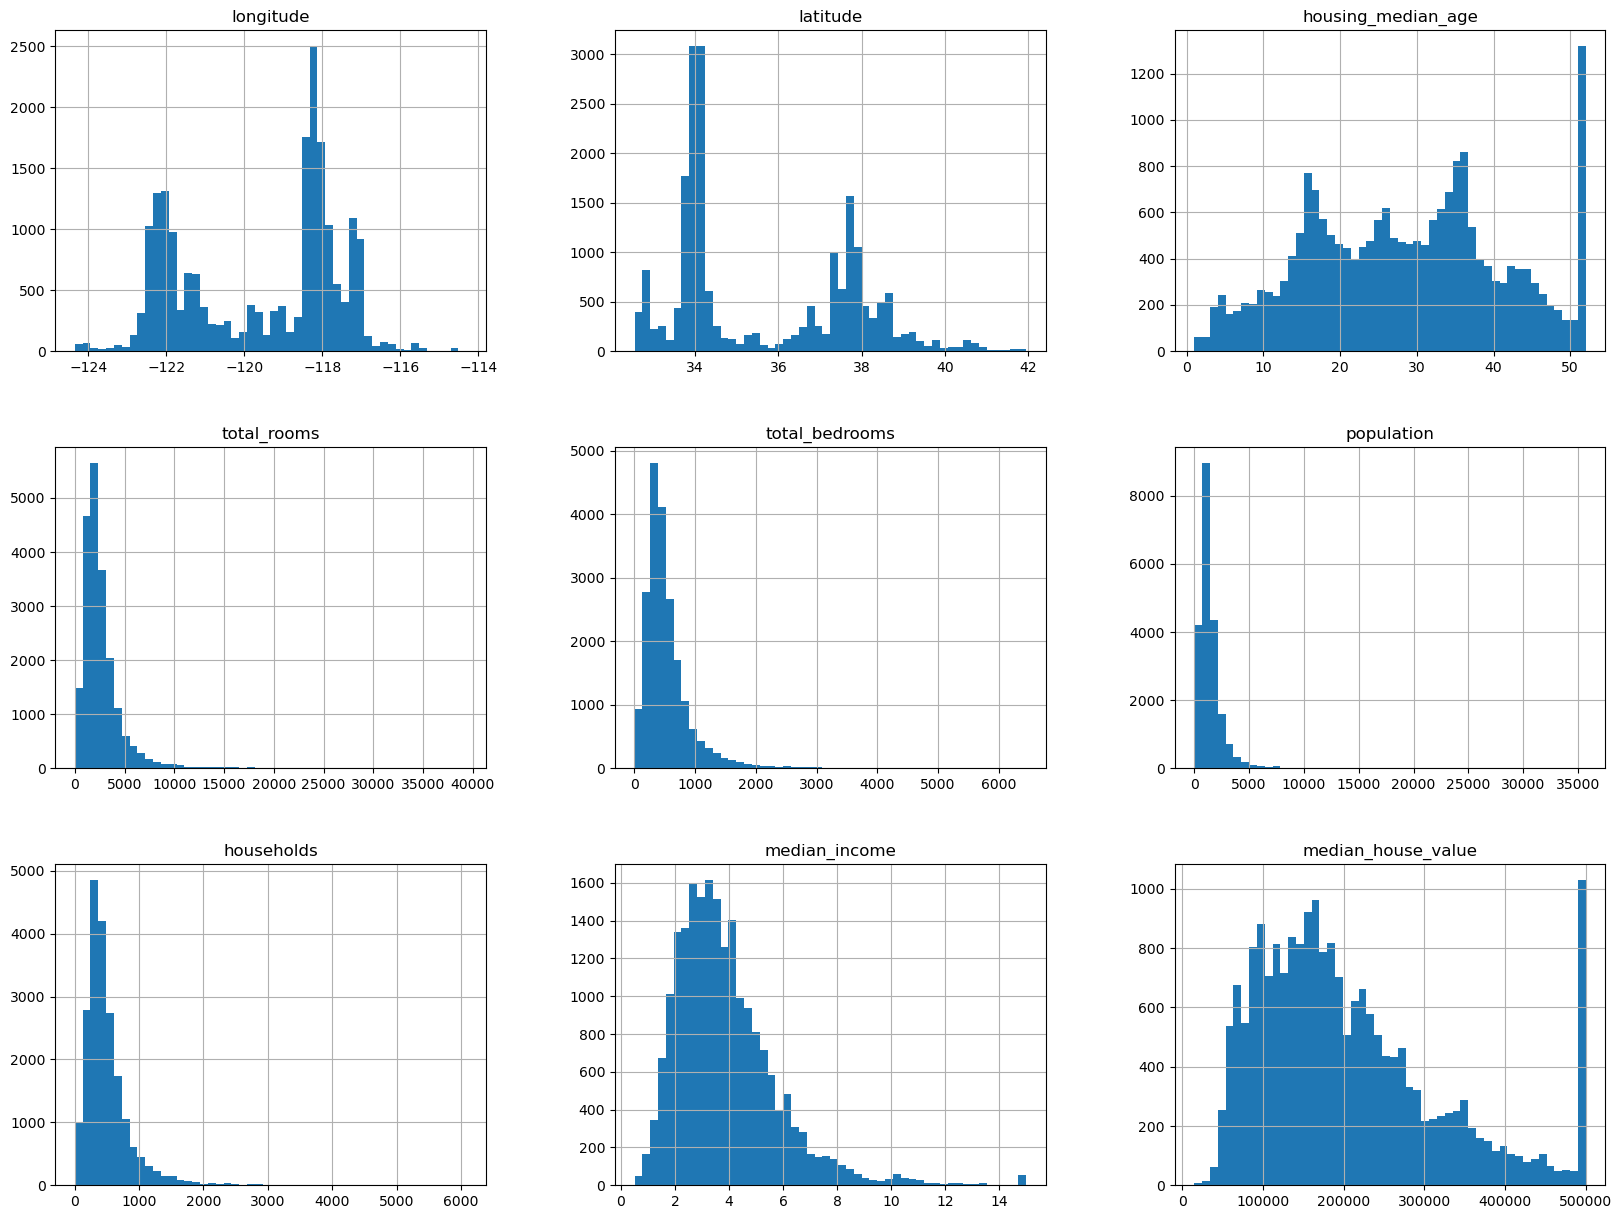

In [58]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20, 15))
plt.show()

In [59]:
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [60]:
train_set, test_set = split_train_test(housing, 0.2)
print(f"Train set size: {len(train_set)}, Test set size: {len(test_set)}")

Train set size: 16512, Test set size: 4128


But the code above is not sufficient because it generates different sets every time we run it. If we run multiple times, we will go through the whole dataset, which should be avoided.

In [61]:
#Another option is to use a hash function to create a unique identifier for each instance, which can be used to split the dataset consistently across runs.
import hashlib

def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio # 256 is the number of possible hash values

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

Unfortunately, the housing dataset does not have an identifier column. The simplest solution is to use the row index as the ID:

In [62]:
#Use row index as the ID
housing_with_id = housing.reset_index()  # Add an index column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")


But if then, you need to make sure that new data gets appended at the end of the dataset, no rows ever gets deleted, as it will messed up the order.

In [63]:
#Using scikit-learn to split the dataset
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

Normally, it will work generally fine if the dataset is large enough, if not, you risk introducing a significant sampling bias.

Now we will perform stratified-sampling to guarantee the test set is is representative  of the overall population.

In [64]:
#Create income category attribute
housing['income_cat'] = np.ceil(housing['median_income'] / 1.5)
housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace=True)  # Cap it at 5.0

C:\Users\ASUS\AppData\Local\Temp\ipykernel_11612\501787361.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace=True)  # Cap it at 5.0


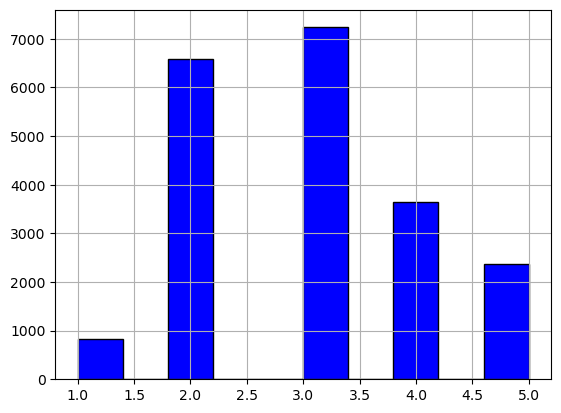

In [65]:
#plot the income category distribution
housing['income_cat'].hist(color='blue', edgecolor='black')
plt.show()

In [66]:
#Stratified Sampling
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [67]:
# Check the data
strat_test_set['income_cat'].value_counts() / len(strat_test_set)


income_cat
3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114341
1.0    0.039971
Name: count, dtype: float64

In [68]:
#Remove the income category attribute
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

## Discover and Visualize the Data to Gain Insights

In [69]:
#Copy the training set to a new variable
housing = strat_train_set.copy()

### Visualizing Geographical Data

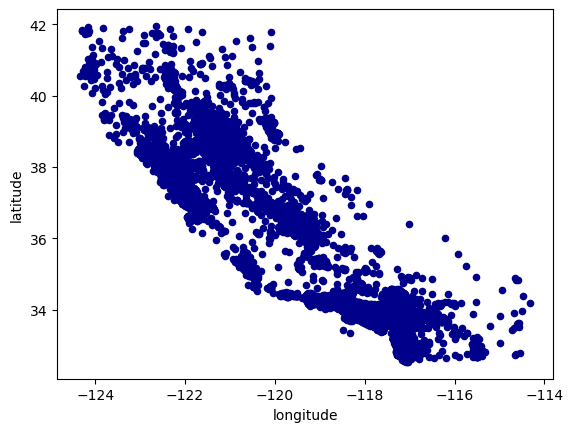

In [70]:
housing.plot(kind='scatter',color='darkblue', x='longitude', y='latitude')
plt.show() 

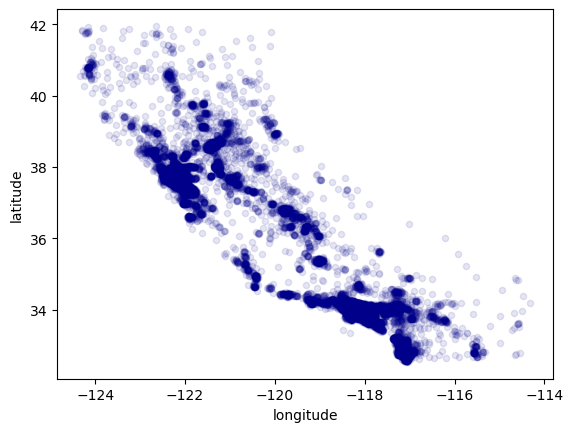

In [71]:
# Add alpha = 0.1 to visualize density
housing.plot(kind='scatter', color='darkblue', x='longitude', y='latitude', alpha=0.1)
plt.show()

The radius of each circle represents the district’s population (option s), and the color represents the price (option c). We will use a predefined color map (option cmap) called jet, which ranges from blue (low values) to red (high prices)

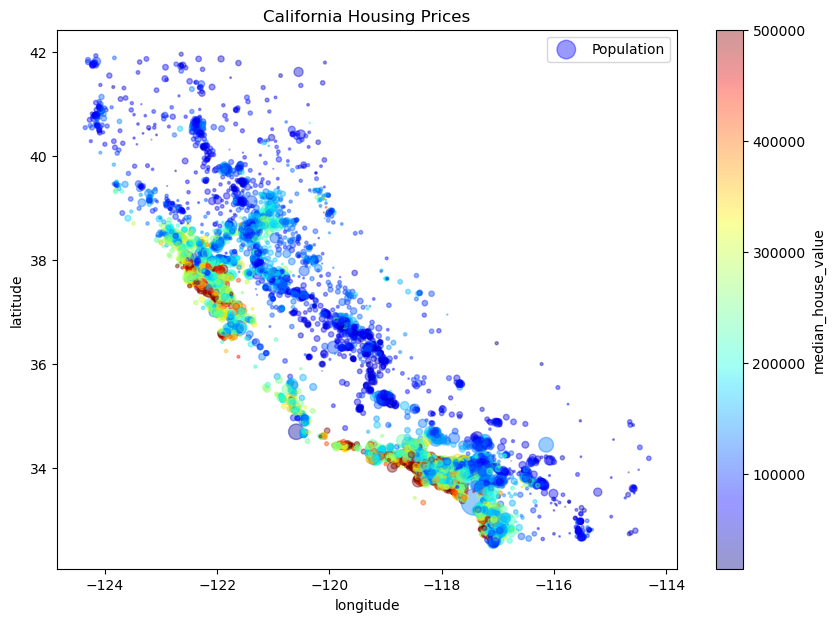

In [72]:
# Use cmap to visualize price and radius for population
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,
             s=housing['population']/100, label='Population', figsize=(10, 7),
             c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True)
plt.title('California Housing Prices')
plt.legend()
plt.show()

### Looking for Correlations

In [73]:
#Correlation Matrix
corr_matrix = housing.corr(numeric_only=True)

In [74]:
# Look at how much each attribute correlates with the median house value
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

When it is close to 1, it means that
there is a strong positive correlation; for example, the median house value tends to go
up when the median income goes up

When the coefficient is close to –1, it means
that there is a strong negative correlation; you can see a small negative correlation
between the latitude and the median house value (i.e., prices have a slight tendency to
go down when you go north)

Finally, coefficients close to zero mean that there is no
linear correlation.

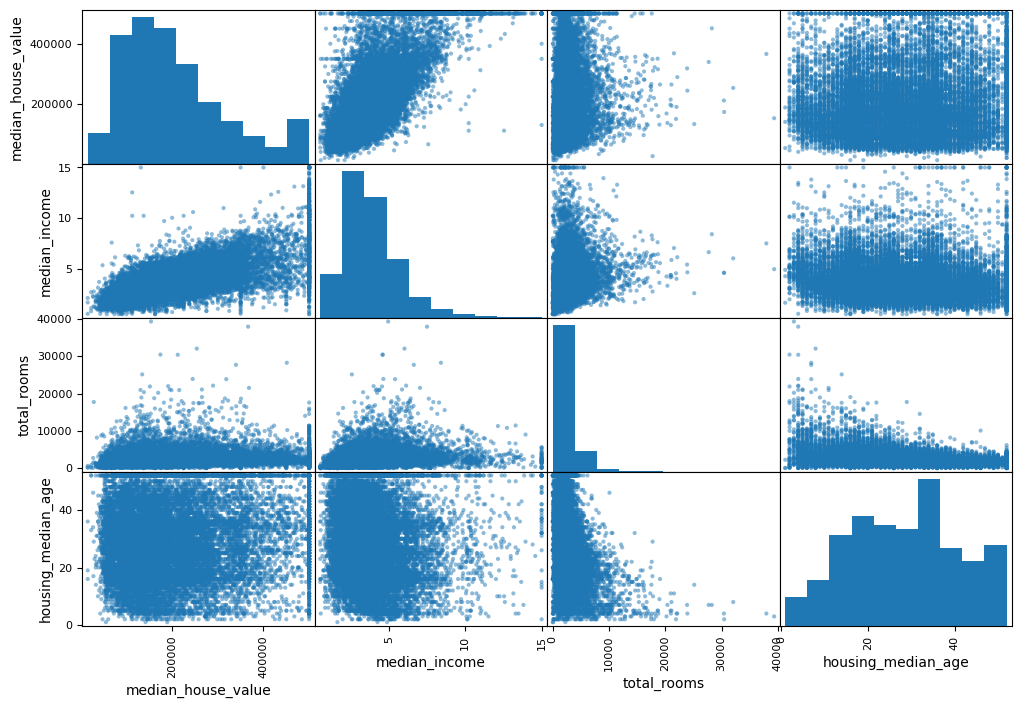

In [75]:
#Check for correlation betweeen attributes
from pandas.plotting import scatter_matrix

attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']

scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

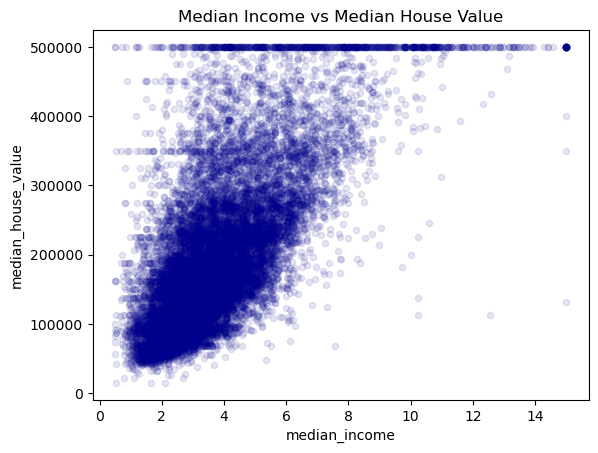

In [76]:
housing.plot(kind="scatter", color='darkblue', x="median_income", y="median_house_value",
alpha=0.1)
plt.title('Median Income vs Median House Value')
plt.show()

First, the correlation is indeed very strong; you can clearly see the upward trend and the points are not too dispersed. 
Second, a horizontal line at $500,000 and the plot also reveals other less obvious straight lines: a horizontal line around $450,000, another around $350,000, perhaps one around $280,000, and a few more below that.
We may want to try removing the corresponding districts to prevent your algorithms from learning to reproduce these data quirks.

### Experimenting with Attribute Combinations

In [77]:
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household'] = housing['population']/housing['households']

In [78]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

bedrooms_per_room attribute is much more correlated with the median house value than the total number of rooms or bedrooms. Apparently houses with a lower bedroom/room ratio tend to be more expensive.

The number of rooms per household is also more informative than the total number of rooms in a district => obviously the larger the houses, the more expensive they are.

## Prepare the Data for Machine Learning Algorithms

In [79]:
#Revert Clean Training Set
housing = strat_train_set.drop("median_house_value", axis=1)  # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()  # labels for training set

### Data Cleaning

the total_bedrooms attribute has some missing values

You have three options:

• Get rid of the corresponding districts.

• Get rid of the whole attribute.

• Set the values to some value (zero, the mean, the median, etc.).

In [80]:
# housing.dropna(subset=["total_bedrooms"]) # option 1
# housing.drop("total_bedrooms", axis=1) # option 2
# median = housing["total_bedrooms"].median() # option 3
# housing["total_bedrooms"].fillna(median, inplace=True)

In [81]:
#Use imputer from sklearn to handle missing values
from sklearn.impute import SimpleImputer

# Create an imputer instance
imputer = SimpleImputer(strategy="median")

#Drop non-numeric attributes
housing_num = housing.drop("ocean_proximity", axis=1)

# Fit the imputer to the numeric data
imputer.fit(housing_num)

,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False


In [82]:
#Check imputer statistics
print(imputer.statistics_)

#Compare with median
print(housing_num.median().values )

[-118.51      34.26      29.      2119.       433.      1164.
  408.         3.54155]
[-118.51      34.26      29.      2119.       433.      1164.
  408.         3.54155]


In [83]:
#Now use the imputer to transform the data
X = imputer.transform(housing_num)

In [84]:
#Put in data frame
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

### Handling Text and Categorical Attributes

In [85]:
housing_cat = housing["ocean_proximity"]
housing_cat.head(10)

12655        INLAND
15502    NEAR OCEAN
2908         INLAND
14053    NEAR OCEAN
20496     <1H OCEAN
1481       NEAR BAY
18125     <1H OCEAN
5830      <1H OCEAN
17989     <1H OCEAN
4861      <1H OCEAN
Name: ocean_proximity, dtype: object

In [86]:
#convert these categories from text to numbers use Pandas's factorize()
housing_cat_encoded, housing_categories = housing_cat.factorize()
housing_cat_encoded[:10]

array([0, 1, 0, 1, 2, 3, 2, 2, 2, 2])

The factorize() method also returns the list of categories (“<1H OCEAN” was mapped to 0, “NEAR OCEAN” was mapped to 1, etc.)

In [87]:
housing_categories

Index(['INLAND', 'NEAR OCEAN', '<1H OCEAN', 'NEAR BAY', 'ISLAND'], dtype='object')

One issue with this representation is that ML algorithms will assume that two nearby values are more similar than two distant values.

Use one-hot encoding, one attribute will be equal to 1 (hot), while the others will be 0 (cold)

In [88]:
#perform one-hot encoding
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1, 1))
housing_cat_1hot

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16512 stored elements and shape (16512, 5)>

fit_transform() expects a 2D array, but housing_cat_encoded is a 1D array, so we need to reshape it.

the output is a SciPy sparse matrix, instead of a NumPy array. This is very useful when you have categorical attributes with thousands of categories.

After one-hot encoding we get a matrix with thousands of columns, and the matrix is full of zeros except for a single 1 per row => Waste Memory.

Use it like normal 2D array, and to convert into dense Numpy array, call toarray() method.

In [89]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.]])

Or you can apply both transformations (from text categories to integer categories, then from integer categories to one-hot vectors) in one shot using the Categorical Encoder class


In [90]:
# #Use categorical encoder
# from sklearn.preprocessing import CategoricalEncoder
# categorical_encoder = CategoricalEncoder(encoding = 'onehot-dense') #Using onehot-dense if you prefer a dense matrix
# housing_cat_reshaped = housing_cat_encoded.reshape(-1, 1)  # fit_transform() expects a 2D array, but housing_cat_encoded is a 1D array, so we need to reshape it.
# housing_cat_1hot = categorical_encoder.fit_transform(housing_cat_reshaped)
# housing_cat_1hot


If you’re using a modern version of scikit-learn (e.g., 1.2 or later), CategoricalEncoder is not available

### Custom Transformer

Creating transformer class that adds the combined attributes.

The transformer has one hyperparameter, add_bedrooms_per_room, allow you to easily find out whether adding this attribute helps the
Machine Learning algorithms or not

In [91]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributeAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        rooms_per_house = X[:, rooms_ix] / X[:, household_ix]
        population_per_house = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_house, population_per_house, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_house, population_per_house]

In [92]:
attr_adder = CombinedAttributeAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [93]:
print(housing_extra_attribs)

[[-121.46 38.52 29.0 ... 'INLAND' 5.485835694050992 3.168555240793201]
 [-117.23 33.09 7.0 ... 'NEAR OCEAN' 6.927083333333333 2.6236979166666665]
 [-119.04 35.37 44.0 ... 'INLAND' 5.3933333333333335 2.223333333333333]
 ...
 [-122.72 38.44 48.0 ... '<1H OCEAN' 4.1104651162790695
  2.6627906976744184]
 [-122.7 38.31 14.0 ... '<1H OCEAN' 6.297405189620759 2.411177644710579]
 [-122.14 39.97 27.0 ... 'INLAND' 5.477157360406092 3.1725888324873095]]


### Feature Scaling

Two common ways to get all attributes to have the same scale: min-max scaling and standardization.

Min-max scaling (many people call this normalization) is quite simple: values are shifted and rescaled so that they end up ranging from 0 to 1.

Unlike min-max scaling, standardization does not bound values to a specific range, but it's much less affected by outliers.

### Transformation Pipelines

In [94]:
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.impute import SimpleImputer

# num_pipeline = Pipeline([
#     ('imputer', SimpleImputer(strategy="median")),
#     ('attribs', CombinedAttributeAdder()),
#     ('scaler', StandardScaler())
# ])
# housing_num_tr = num_pipeline.fit_transform(housing_num)

Create Transformer to select attributes

In [95]:
#Create Data Selector Transformer
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.attribute_names].values

Create Pipelines for Numerical and Categorical Attributes

In [96]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

In [98]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

#Create Numerical Pipeline
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs', CombinedAttributeAdder()),
    ('scaler', StandardScaler())
])

In [99]:
#Create Categorical Pipeline
cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('cat_encoder', OneHotEncoder(handle_unknown="ignore"))
])

In [100]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

In [101]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared.toarray()[:5]

array([[-0.94135046,  1.34743822,  0.02756357,  0.58477745,  0.64037127,
         0.73260236,  0.55628602, -0.8936472 ,  0.01739526,  0.00622264,
        -0.12112176,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.17178212, -1.19243966, -1.72201763,  1.26146668,  0.78156132,
         0.53361152,  0.72131799,  1.292168  ,  0.56925554, -0.04081077,
        -0.81086696,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, -0.46977281, -0.54513828,
        -0.67467519, -0.52440722, -0.52543365, -0.01802432, -0.07537122,
        -0.33827252,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.22173797, -1.35147437, -0.37006852, -0.34865152, -0.03636724,
        -0.46761716, -0.03729672, -0.86592882, -0.59513997, -0.10680295,
         0.96120521,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [ 0.43743108, -0.63581817, -0

In [102]:
housing_prepared.shape

(16512, 16)

## Select and Train Model

### Train and Evaluate on Training Set

#### Linear Regression

In [103]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [104]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

In [105]:
print('Predictions:', lin_reg.predict(some_data_prepared))

print("Labels:", list(some_labels))

Predictions: [ 85657.90896311 305492.62323584 152056.4534063  186095.72583397
 244550.67397153]
Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [107]:
#Save LR model
import joblib

joblib.dump(lin_reg, "models/lin_regressor.pkl")  # Save the trained model to a file named 'lin_regressor.pkl'

['models/lin_regressor.pkl']

It works, although the predictions are not exactly accurate. Use RMSE on the whole training set.

In [108]:
#Evaluate using RMSE
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)

lin_mse = mean_squared_error(housing_labels, housing_predictions)

lin_rmse = np.sqrt(lin_mse)

lin_rmse


np.float64(68627.873900191)

This result is not a great score. It means most districts’ median_housing_values range between $120,000 and $265,000, so a typical prediction error of $68,628.

This is an example of a model underfitting the training data.

Now try DecisionTree, a powerful model, capable of finding complex nonlinear relationships in the data

#### Decision Tree

In [109]:
#Train DecisionTree
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()

tree_reg.fit(housing_prepared, housing_labels)

,criterion,'squared_error'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [110]:
#Evaluate on the training set
tree_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, tree_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

np.float64(0.0)

This shows model has badly overfitted the data.

In [111]:
#Save Tree
joblib.dump(tree_reg, "models/tree_regressor.pkl")  # Save the trained model to a file named 'tree_regressor.pkl'

['models/tree_regressor.pkl']

### Better Evaluation Using Cross Validation

In [112]:
#Perform Cross-Validation techinique
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [113]:
#Display the score
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [73149.56046628 69430.0657562  68171.17775841 71480.73215781
 70214.6191888  78164.09491831 69264.91730506 73454.03953059
 68405.06609274 72509.88975369]
Mean: 71424.4162927884
Standard deviation: 2889.7179889884846


In [114]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                              scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [71762.76438213 64114.99188122 67771.16741431 68635.19072068
 66846.14471914 72528.03734016 73997.07965239 68802.33600875
 66443.28863097 70139.80032775]
Mean: 69104.0801077498
Standard deviation: 2880.328001448838


The Decision Tree model is overfitting so badly that it performs worse than the Linear Regression model

#### Random Forest

In [115]:
#Try RandomForest Regressor
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()

forest_reg.fit(housing_prepared, housing_labels)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [116]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                  scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [51468.56062808 49071.95512908 46795.56333544 52106.97156234
 47576.29320426 51181.65961834 52323.05266164 49555.33640462
 49044.7158982  53906.62068431]
Mean: 50303.07291263125
Standard deviation: 2141.1766753848588


In [117]:
#Save the model and hyperparameters
joblib.dump(forest_reg, "models/forest_regressor.pkl")  # Save the trained model to a file named 'my_model.pkl'


['models/forest_regressor.pkl']

#### Support Vector Regression

In [118]:
#Try different models with varying hyperparameters
from sklearn.svm import SVR

svr = SVR(kernel='linear', C=1.0, epsilon=0.1)
svr.fit(housing_prepared, housing_labels)

,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,tol,0.001
,C,1.0
,epsilon,0.1
,shrinking,True
,cache_size,200
,verbose,False
,max_iter,-1


In [119]:
#Evaluate
svr_prediction = svr.predict(housing_prepared)

svr_mse = mean_squared_error(housing_labels, svr_prediction)

svr_rmse = np.sqrt(svr_mse)

svr_rmse

np.float64(111095.06635291968)

In [120]:
svr_scores = cross_val_score(svr, housing_prepared, housing_labels,
                                  scoring="neg_mean_squared_error", cv=10)
svr_rmse_scores = np.sqrt(-svr_scores)
display_scores(svr_rmse_scores)

Scores: [110518.40356474 112956.5486846  106998.56227015 113590.97575445
 107782.52294955 116063.7781669  113279.08892636 111836.81295967
 113168.96643781 111945.40954593]
Mean: 111814.1069260169
Standard deviation: 2600.840269089257


This is by far the worse one

Fine-tune SVR with RandomizedCV


In [121]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR

# Define the parameter grid for RandomizedSearchCV
param_grid = [
    {
        'kernel': ['linear'],
        'C': [0.1, 1, 10, 100],
        'epsilon': [0.01, 0.1, 0.5]
    },
    {
        'kernel': ['rbf'],
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.01, 0.1],
        'epsilon': [0.01, 0.1, 0.5]
    }
]

# Initialize the SVR model
svr = SVR()

# Perform RandomizedSearchCV with cross-validation
random_search = RandomizedSearchCV(svr, param_grid, n_iter=100, cv=5, random_state=42)
random_search.fit(housing_prepared, housing_labels)


# Print the best parameters and score
print("Best Parameters: ", random_search.best_params_)
print("Best Score: ", random_search.best_score_)


d:\Anaconda\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 60 is smaller than n_iter=100. Running 60 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters:  {'kernel': 'linear', 'epsilon': 0.01, 'C': 100}
Best Score:  0.6165888240693436


#### Gradient Boosting 

In [122]:
#Use gradient boosting
from sklearn.ensemble import GradientBoostingRegressor

gbm = GradientBoostingRegressor()

gbm.fit(housing_prepared, housing_labels)


,loss,'squared_error'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [123]:
gbm_scores = cross_val_score(gbm, housing_prepared, housing_labels,
                                  scoring="neg_mean_squared_error", cv=10)
gbm_rmse_scores = np.sqrt(-gbm_scores)
display_scores(gbm_rmse_scores)


Scores: [54570.66192762 51218.74606634 49287.03489296 55776.95426996
 50913.95837692 53311.54539954 54943.12239109 53338.21982849
 50888.97975466 55899.18199049]
Mean: 53014.840489806884
Standard deviation: 2198.5367208163248


In [124]:
#Save GBM
joblib.dump(gbm, "models/gbm_regressor.pkl")  # Save the trained model to a file named 'gbm_regressor.pkl'

['models/gbm_regressor.pkl']

### Fine-tuning Models

In [125]:
#Using GridSearch for fine-tuning
from sklearn.model_selection import GridSearchCV

models = [
    ("Linear Regression", LinearRegression()),
    ("Decision Tree", DecisionTreeRegressor(random_state=42)),
    ("Random Forest", RandomForestRegressor(random_state=42)),
    ("Gradient Boosting", GradientBoostingRegressor(random_state=42))
    
]

param_grids = {
    "Linear Regression": {
        "fit_intercept": [True, False]
    },
    "Decision Tree": {
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4]
    },
    "Random Forest": {
        "n_estimators": [3, 10, 30], "max_features": [2, 4, 6, 8],
        "max_depth": [None, 10, 20],
        "bootstrap": [False]
    },
    "Gradient Boosting": {
        "n_estimators": [100, 200],
        "learning_rate": [0.01, 0.1, 1],
        "max_depth": [3, 5, 7]
    }
}

# 3. Perform grid search and store results
results = []
for name, model in models:
    print(f"Training {name}...")
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        cv=5,
        scoring="neg_mean_squared_error",
        n_jobs=-1,  # Use all CPU cores
        verbose=1
    )
    grid_search.fit(housing_prepared, housing_labels)

    # Get best model and its score
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_cv_rmse = np.sqrt(-grid_search.best_score_)  # Convert to positive RMSE

# Store results
results.append({
    "model": name,
    "best_model": best_model,
    "best_params": best_params,
    "best_cv_rmse": best_cv_rmse
})


Training Linear Regression...
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Training Decision Tree...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Training Random Forest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Training Gradient Boosting...
Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [126]:
results

[{'model': 'Gradient Boosting',
  'best_model': GradientBoostingRegressor(max_depth=7, n_estimators=200, random_state=42),
  'best_params': {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200},
  'best_cv_rmse': np.float64(46440.687454625644)}]

#### Analyze the Best Models and Their Errors

In [127]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.50910834e-02, 6.51800678e-02, 3.91554837e-02, 8.96611113e-03,
       8.19066797e-03, 8.10755113e-03, 8.43841232e-03, 4.87304929e-01,
       2.06588452e-02, 1.20488770e-01, 1.51376527e-02, 1.58786007e-03,
       1.38954992e-01, 2.47887790e-05, 8.33094958e-04, 1.87969002e-03])

In [128]:
#display these importance scores next to their corresponding attribute names
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = cat_pipeline.named_steps["cat_encoder"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(np.float64(0.48730492869926234), 'median_income'),
 (np.float64(0.1389549919272522), 'INLAND'),
 (np.float64(0.12048877022245764), 'pop_per_hhold'),
 (np.float64(0.07509108336202844), 'longitude'),
 (np.float64(0.06518006783092832), 'latitude'),
 (np.float64(0.03915548370294745), 'housing_median_age'),
 (np.float64(0.020658845182617763), 'rooms_per_hhold'),
 (np.float64(0.01513765269268501), 'bedrooms_per_room'),
 (np.float64(0.008966111133778097), 'total_rooms'),
 (np.float64(0.008438412319920542), 'households'),
 (np.float64(0.008190667969186438), 'total_bedrooms'),
 (np.float64(0.00810755112991927), 'population'),
 (np.float64(0.0018796900196030866), 'NEAR OCEAN'),
 (np.float64(0.0015878600707710212), '<1H OCEAN'),
 (np.float64(0.0008330949576840901), 'NEAR BAY'),
 (np.float64(2.478877895837408e-05), 'ISLAND')]

### Evaluate The Final System on Test Set

In [129]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

final_rmse

np.float64(44661.53431045615)